# SDA OD-2: Оценка эффективности новой фичи
С 1 июня 2019 внедряется новая фича. Задача, оценить ее эффективность по первому месяцу в сравнении с теми же показателями предыдущего месяца.  
  
### Задача: Посчитать показатели Retention Rate седьмого дня и ARPPU за 2 периода до и после внедрения фичи

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras 
import seaborn as sns
from matplotlib import pyplot as plt

## Считаем количество зарегистрировавшихся пользователей за май и июнь 2019
То же, что в модуле, но за 2 месяца: май и июнь.
Получаем датафрейм **registered_users_count**

In [2]:
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-07-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count = pd.DataFrame(getRegisteredUsersCount())

In [3]:
registered_users_count['registration_date'] = pd.to_datetime(registered_users_count['registration_date'])
registered_users_count['registered_users_count'].sum()

289366

## Получаем данные об активных пользователях
Создаем датафрейм **active_users_count_with_cohorts** активных пользователей с когортами

In [4]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())

## Создаем объединенный датафрейм и считаем Retention Rate

In [5]:
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col])

retention_table = active_users_count_with_cohorts.merge(registered_users_count,on=['registration_date'],how='left')
retention_table['retention_rate'] = retention_table['active_users_count'] / retention_table['registered_users_count']
retention_table['lifetime'] = retention_table['activity_date'] - retention_table['registration_date']
retention_table['lifetime'] = retention_table['lifetime']/np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime'].astype(int) 
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime
0,2019-05-01,2019-05-01,2590,6516,0.397483,0
1,2019-05-02,2019-05-01,2146,6516,0.329343,1
2,2019-05-02,2019-05-02,2049,5309,0.385948,0
3,2019-05-03,2019-05-01,1637,6516,0.251228,2
4,2019-05-03,2019-05-02,1817,5309,0.342249,1


## Создаем сводную Retention Rate по когортам

In [6]:
retention_pivot = retention_table.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='sum')
retention_pivot.head()

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,0.397483,0.329343,0.251228,0.222683,0.198895,0.174954,0.153929,0.146255,0.133671,0.123082,...,0.072284,0.069828,0.068754,0.067219,0.067373,0.063536,0.062922,0.060773,0.043738,0.029619
2019-05-02,0.385948,0.342249,0.254285,0.219062,0.193633,0.164061,0.152006,0.140328,0.125071,0.117160,...,0.067056,0.059522,0.059898,0.061217,0.060652,0.058768,0.055943,0.053682,0.045018,0.031456
2019-05-03,0.381264,0.339291,0.256783,0.219438,0.188477,0.170124,0.148899,0.142834,0.132301,0.126716,...,0.071976,0.070859,0.072455,0.069103,0.067028,0.066550,0.063837,0.060166,0.046920,0.030961
2019-05-04,0.384651,0.335224,0.241232,0.191573,0.169348,0.150249,0.140178,0.137284,0.131728,0.116796,...,0.072925,0.071420,0.066906,0.065401,0.064012,0.061465,0.058456,0.057646,0.043176,0.029286
2019-05-05,0.383161,0.311944,0.227751,0.192398,0.170737,0.152549,0.145397,0.138755,0.121488,0.113518,...,0.067641,0.063962,0.061101,0.060693,0.058547,0.057014,0.053438,0.054256,0.043936,0.027179


## Сделаем тепловую карту для наглядности
оказалась совешенно непоказательной, но лишний раз проверить не повредит

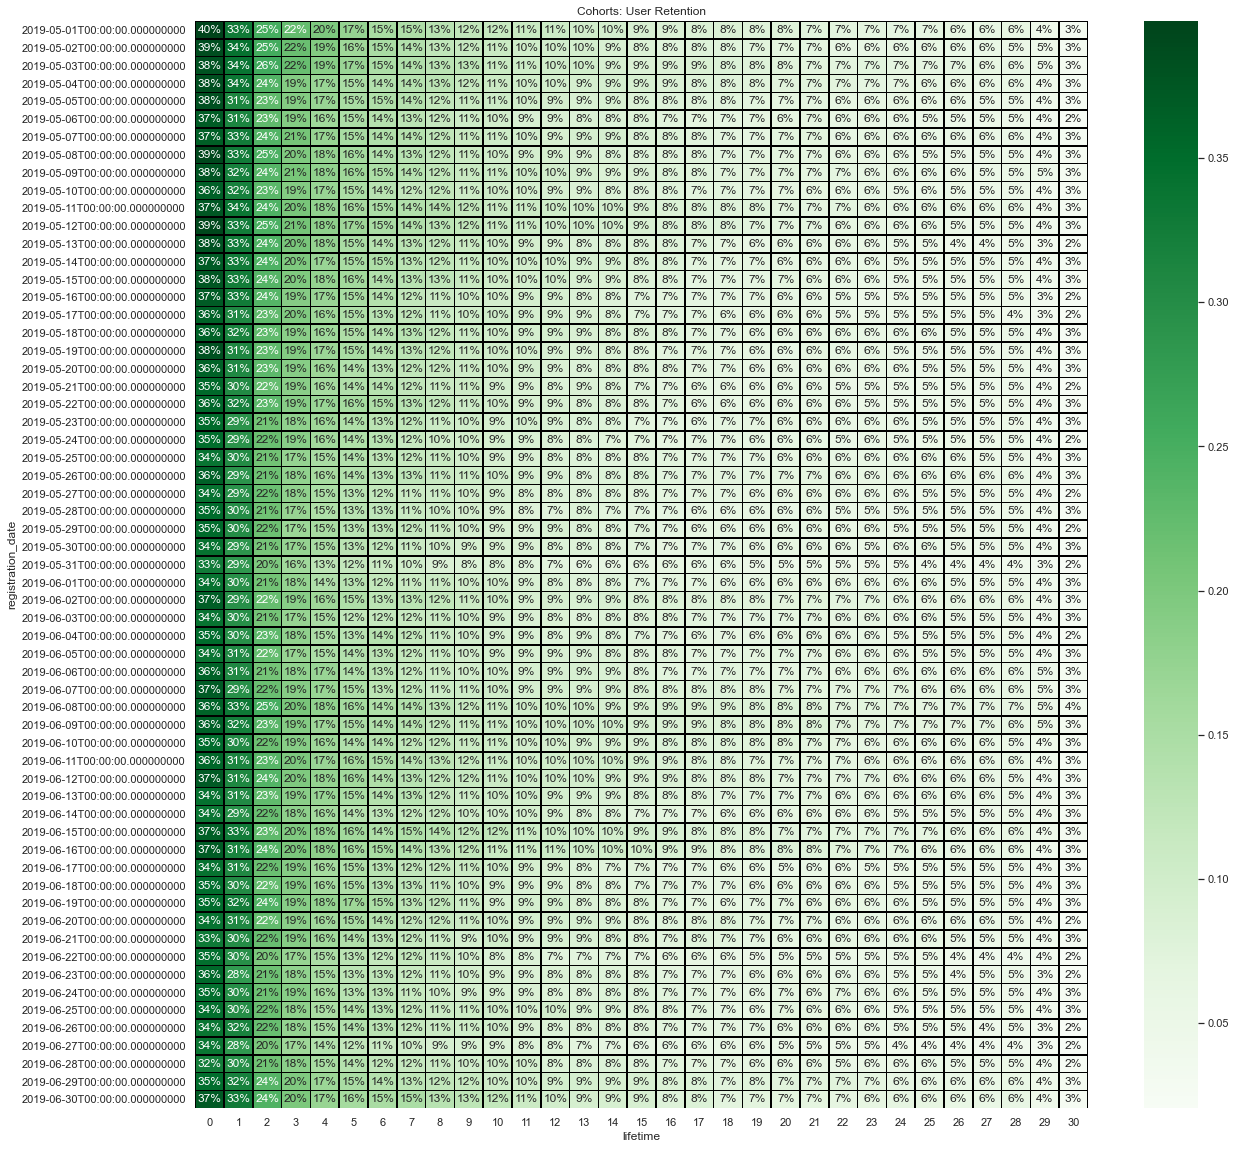

In [7]:
sns.set(style='white')
plt.figure(figsize=(20, 20))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, mask=retention_pivot.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black', cmap="Greens");

In [8]:
# retention_pivot[0].plot.bar() # еще пара непоказательных графиков

In [9]:
# retention_pivot[7].plot.bar() 

In [10]:
retention_pivot[7]['2019-06-30']/retention_pivot[7]['2019-06-01']

1.3244076718481195

### Изменение Retention Rate за июнь (с момента внедрения фичи)
RR когорты 30 июня 2019 на седьмой день 132% относительно того же показателя когорты 1 июня 2019  
  


## Считаем Retention Day-7 до и после фичи

In [11]:
dates_for_rrd7 = ['2019-05-01','2019-05-15','2019-05-31','2019-06-01','2019-06-15','2019-06-30']
for i in dates_for_rrd7:
    print(f"Retention Rate Day-7 когорты {i}: {retention_pivot[7][i]:.2%}")



Retention Rate Day-7 когорты 2019-05-01: 14.63%
Retention Rate Day-7 когорты 2019-05-15: 13.26%
Retention Rate Day-7 когорты 2019-05-31: 10.08%
Retention Rate Day-7 когорты 2019-06-01: 11.28%
Retention Rate Day-7 когорты 2019-06-15: 14.51%
Retention Rate Day-7 когорты 2019-06-30: 14.93%


---
Похоже, что фича работает. RR(7) до внедрения упал за месяц с 14.63% до 10.08%.  
После внедрения вырос с 11.28% до 14.93%
---

## Создаем датафрейм с выручкой  

In [12]:
def getRevenue():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue = pd.DataFrame(getRevenue())

In [13]:
for col in ['date','registration_date']:
    revenue[col] = pd.to_datetime(revenue[col])

In [14]:
print(f"Выручка за май: {revenue[revenue.registration_date.dt.month==5]['revenue'].sum()}")
print(f"Выручка за июнь: {revenue[revenue.registration_date.dt.month==6]['revenue'].sum()}")
print(f"Падение на {(revenue[revenue.registration_date.dt.month==5]['revenue'].sum()-revenue[revenue.registration_date.dt.month==6]['revenue'].sum())/revenue[revenue.registration_date.dt.month==5]['revenue'].sum():.2%}")

Выручка за май: 121998.28041
Выручка за июнь: 79685.872927
Падение на 34.68%


In [15]:
print(f"Зарегистрированные пользователи за май: {registered_users_count[registered_users_count.registration_date.dt.month==5]['registered_users_count'].sum()}")
print(f"Зарегистрированные пользователи за июнь: {registered_users_count[registered_users_count.registration_date.dt.month==6]['registered_users_count'].sum()}")
print(f"Падение на {(registered_users_count[registered_users_count.registration_date.dt.month==5]['registered_users_count'].sum()-registered_users_count[registered_users_count.registration_date.dt.month==6]['registered_users_count'].sum())/registered_users_count[registered_users_count.registration_date.dt.month==5]['registered_users_count'].sum():.2%}")

Зарегистрированные пользователи за май: 188943
Зарегистрированные пользователи за июнь: 100423
Падение на 46.85%


In [16]:
print(f"Средняя выручка за месяц с пользователей, зарегитстрировавшихся в мае: {revenue[revenue.registration_date.dt.month==5]['revenue'].sum()/registered_users_count[registered_users_count.registration_date.dt.month==5]['registered_users_count'].sum()}")
print(f"Средняя выручка за месяц с пользователей, зарегитстрировавшихся в июне: {revenue[revenue.registration_date.dt.month==6]['revenue'].sum()/registered_users_count[registered_users_count.registration_date.dt.month==6]['registered_users_count'].sum()}")

Средняя выручка за месяц с пользователей, зарегитстрировавшихся в мае: 0.6456882785284451
Средняя выручка за месяц с пользователей, зарегитстрировавшихся в июне: 0.793502214900969


---
Получаются удручающие цифры по изменению общей выручки и количеству зарегистрировавшихся пользователей.
## Объединяем датафреймы и считаем ARPPU

In [17]:
revenue = revenue.rename(columns={'date':'activity_date'})
retention_table_with_revenue = retention_table.merge(revenue,on=['registration_date','activity_date'],how='left')
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue[col] = retention_table_with_revenue[col].fillna(0)
retention_table_with_revenue['users_count_with_revenue'] = retention_table_with_revenue['users_count_with_revenue'].astype(int)
retention_table_with_revenue['arpu'] = retention_table_with_revenue['revenue'] / retention_table_with_revenue['active_users_count']
retention_table_with_revenue['arppu'] = retention_table_with_revenue['revenue']/retention_table_with_revenue['users_count_with_revenue']

In [18]:
retention_table_with_revenue.head(5)

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue,arpu,arppu
0,2019-05-01,2019-05-01,2590,6516,0.397483,0,1672,2357.580,0.910263,1.410036
1,2019-05-02,2019-05-01,2146,6516,0.329343,1,1420,514.679,0.239832,0.362450
2,2019-05-02,2019-05-02,2049,5309,0.385948,0,1367,1629.140,0.795090,1.191763
3,2019-05-03,2019-05-01,1637,6516,0.251228,2,1048,390.952,0.238822,0.373046
4,2019-05-03,2019-05-02,1817,5309,0.342249,1,1164,533.608,0.293675,0.458426


## Теперь посчитаем ARPPU

In [19]:
arppu_cohorts = retention_table_with_revenue[
    (retention_table_with_revenue['lifetime'] == 7) 
    & (retention_table_with_revenue['registration_date'].isin(['2019-05-01','2019-05-15','2019-05-31','2019-06-01','2019-06-15','2019-06-30']))
       ][['users_count_with_revenue','arpu','arppu']].groupby(
           retention_table_with_revenue['registration_date']).mean().reset_index()
arppu_cohorts

,registration_date,users_count_with_revenue,arpu,arppu
0,2019-05-01,616,0.067058,0.103744
1,2019-05-15,526,0.301108,0.452234
2,2019-05-31,309,0.248471,0.382757
3,2019-06-01,365,0.323516,0.483058
4,2019-06-15,312,0.172381,0.272383
5,2019-06-30,325,0.075083,0.113894


---
По тем же срезам, что и Retention Rate результат получается непоказательным, поэтому посчитаем средний показатель за месяц.

---

In [20]:
retention_table_with_revenue['arppu'] = retention_table_with_revenue['arppu'].fillna(0)
arpu_pivot = retention_table_with_revenue[['users_count_with_revenue','arpu','arppu']].groupby(retention_table_with_revenue['registration_date'].dt.month).mean().reset_index()
m = {5:'May',6:'June'}
arpu_pivot = arpu_pivot.rename(columns = {'registration_date':'month','users_count_with_revenue':'paying_users'})
arpu_pivot.month = arpu_pivot.month.map(m)
arpu_pivot

,month,paying_users,arpu,arppu
0,May,414.698231,0.147619,0.226990
1,June,217.917204,0.186537,0.287751


In [21]:
print('Изменения между маем и июнем:')
print(f"Количество платящих пользователей: {(arpu_pivot['paying_users'][1] - arpu_pivot['paying_users'][0]) / arpu_pivot['paying_users'][0]:+.2%}")
print(f"ARPU: {(arpu_pivot['arpu'][1] - arpu_pivot['arpu'][0]) / arpu_pivot['arpu'][0]:+.2%}")
print(f"ARPPU: {(arpu_pivot['arppu'][1] - arpu_pivot['arppu'][0]) / arpu_pivot['arppu'][0]:+.2%}")

Изменения между маем и июнем:
Количество платящих пользователей: -47.45%
ARPU: +26.36%
ARPPU: +26.77%


---
ARPPU вырос более чем на 26% после внедрения фичи.  При этом количество платящих пользователей упало вдвое.  

---

# Выводы
По формальной задаче у нас отличные показатели:  
До внедрения фичи Retention Rate седьмого дня за месяц упал с 14.6% до 10.1%.  
После внедрения тот же показатель вырос с 11.3% до 15%.  
  
ARPPU в мае: 0.2267
ARPPU в июне: 0.2878
Рост почти на 27%

### Однако!
Зарегистрированные пользователи за май: 188943  
Зарегистрированные пользователи за июнь: 100423  
Падение на 46.85%  
  
Выручка за май: 121998.28  
Выручка за июнь: 79685.87  
Падение на 34.7%  
  
## Заключение
Похоже, преданным фанатам понравилась фича, и они стали тратить больше денег. Все же многих фича оттолкнула, и количество зарегистрированных пользователей сократилось почти вдвое, что привело к снижению общей выручки на треть.